In [1]:
# попробовать als и bpr, разную длину эмбэдингов (factors), затухание от времени, разные гиперпараметы,
# взвешивание матрицы, в матрице не число продаж, а выручку или кол-во уникальных юзеров 
# которые купили товар кол-во пользователей которые купили этот товар 2 раза или больше,
# разные типы фильтрации, количесво итераций, регуляризаци. Рекомендовать рекомендации
# похожих пользователей или их реальные покупки, рекомендовать через itemitem или через топ популярных,
# разное количество топ товаров, LightFM

In [2]:
# Реализовать обработку холодных юзеров

In [3]:
# Оценить recall@k для первого фильтра, чтобы выбрать топ 5000 или 10000(...) товаров 
# оставить на первом этапе и протестировать prefilter_items

In [4]:
# реализовать в классе bpr и lightfm и добавить фичи als, bpr и lightfm в модель lightgbm

In [5]:
# попробовать als и bpr, разную длину эмбэдингов (factors), затухание от времени, разные гиперпараметы,
# взвешивание матрицы, в матрице не число продаж, а выручку или кол-во уникальных юзеров 
# которые купили товар кол-во пользователей которые купили этот товар 2 раза или больше,
# разные типы фильтрации, количесво итераций, регуляризаци. Рекомендовать рекомендации
# похожих пользователей или их реальные покупки, рекомендовать через itemitem или через топ популярных,
# разное количество топ товаров, LightFM

In [6]:
# Исследовать recall у bpr на первом уровне

# 1. Подготовка данных

In [1]:
# на гпу только эта версия работает
!pip install implicit==0.4.0
#!pip install implicit==0.4.2

     |████████████████████████████████| 1.1MB 9.5MB/s 
  Created wheel for implicit: filename=implicit-0.4.0-cp36-cp36m-linux_x86_64.whl size=3390338 sha256=20c1cbbfff458c53a3b794d5216a6196bb5ddd29ca616654647cc88a0aaed79f
  Stored in directory: /root/.cache/pip/wheels/fd/d1/66/84e83191d9f626c521271023e4ef83e634e3b8c154f2c4b2da
Successfully built implicit


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp /content/drive/'My Drive'/retail_train.csv /content
!cp /content/drive/'My Drive'/product.csv /content
!cp /content/drive/'My Drive'/hh_demographic.csv /content
!cp -r /content/drive/'My Drive'/src /content

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
from lightgbm import LGBMRanker
import lightgbm

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import recall_at_k#, precision_at_k
#from src.utils import prefilter_items
#from src.recommenders import MainRecommender

In [5]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [6]:
print(data_train_lvl_1['item_id'].nunique())
print(data_train_lvl_2['item_id'].nunique())
print(data_val_lvl_2['item_id'].nunique())

83685
27649
24329


In [7]:
def precision_at_k(recommended_list, bought_list, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)

    bought_list = bought_list  # Тут нет [:k] !!

    if k < len(recommended_list):
        recommended_list = recommended_list[:k]

    flags = np.isin(bought_list, recommended_list)

    precision = flags.sum() / len(recommended_list)

    return precision

In [8]:
def money_precision_at_k(recommended_list, bought_list, prices_recommended, k=5):
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    prices_recommended = np.array(prices_recommended)


    if k < len(recommended_list):
        recommended_list = recommended_list[:k]
        prices_recommended = prices_recommended[:k]

    flags = np.isin(recommended_list, bought_list)
    res = np.dot(flags, prices_recommended) / np.sum(prices_recommended)

    return res

In [9]:
def recall_at_k(recommended_list, bought_list, k=5):
    import numpy as np
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    recommended_list = recommended_list[:k]
    flags = np.isin(bought_list, recommended_list)
    recall = flags.sum() / len(bought_list)

    return recall

# 2. Класс MainRecommender

In [10]:
import pandas as pd
import numpy as np

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from implicit.bpr import BayesianPersonalizedRanking

class MainRecommender:
    """Рекоммендации, которые можно получить из ALS
    Input
    -----
    user_item_matrix: pd.DataFrame
        Матрица взаимодействий user-item
    """

    def __init__(self, data, item_features, weighting='bm25_weight', model_type = 'als', n_factors=160, 
                    regularization=0.001, iterations=30, num_threads=32, random_state=None):

        self.random_state = random_state
#----------------------------------------------------------------------------------------------------
        # Топ покупок каждого юзера
        self.top_purchases = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != 999999]
#----------------------------------------------------------------------------------------------------
        # Топ покупок по всему датасету
        self.overall_top_purchases = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != 999999]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)
#----------------------------------------------------------------------------------------------------
        # Параметры взвешивания
        if weighting =='bm25_weight':
          self.user_item_matrix = bm25_weight(self.user_item_matrix.T, K1=80, B=0.6).T
        elif weighting =='tfidf_weight':
          self.user_item_matrix = tfidf_weight(self.user_item_matrix.T).T
        else:
          pass

#----------------------------------------------------------------------------------------------------
        # Обучение модели коллаборативной фильтрации
        self.model = self.fit(self.user_item_matrix, 
                              model_type = model_type,
                              n_factors=n_factors, 
                              regularization=regularization, 
                              iterations=iterations,
                              num_threads=num_threads)
#----------------------------------------------------------------------------------------------------
        # Обучение модели на основе KNN
        self.own_recommender = self.fit_own_recommender(self.user_item_matrix)

#----------------------------------------------------------------------------------------------------
        # Сохранение признаков, извлеченных из als (bpr)
        self.als_user_factors = self.model.user_factors
        self.als_item_factors = self.model.item_factors

#----------------------------------------------------------------------------------------------------
        # Датафрейм, индексами которого являются товары, а столбцами - 
        # средняя цена по входному датасету для каждого товара и sub_commodity_desc для товара
        self.item_info = data.groupby('item_id').agg({'sales_value':'sum','quantity':'sum'})\
                                                                                    .reset_index()
        # mean_price - результат деления суммы всех sales_value для товара на сумму всех quantity
        # для товара, так как товар может за один раз продаться несколько раз
        self.item_info['mean_price'] = self.item_info['sales_value']/\
                                                                  self.item_info['quantity']
        self.item_info = self.item_info.merge\
                (item_features[['item_id', 'sub_commodity_desc']], how='left', on='item_id')

        self.item_info.index = self.item_info['item_id']
        self.item_info.drop(columns=['sales_value','quantity','item_id'], inplace=True)

#----------------------------------------------------------------------------------------------------
        # Датафрейм, индексами которого являются пользователи, а столбцом - список всех
        # уникальных товаров, которые купил пользователь
        self.users_purchases = data.groupby('user_id')['item_id'].unique().reset_index()
        self.users_purchases.index = self.users_purchases['user_id']
        self.users_purchases.drop(columns = 'user_id', inplace=True)

#----------------------------------------------------------------------------------------------------
        # Датафрейм, индексами которого являются пользователи, а столбцом - 
        # топ товаров, наиболее часто покупаемых пользователем (стоимость товаров выше mprice_theashold)
        mprice_theashold = 4
        data_reduce = data[data['price'] > 4]
        data_reduce = data_reduce[data_reduce['item_id'] != 999999]

        # Датафрейм "user_id - общее количество покупок пользователем товаров стоимостью выше mprice_theashold"
        user_purchases = data_reduce.groupby(['user_id'])['quantity'].sum().reset_index()
        user_purchases.rename(columns={'quantity': 'user_purchases'}, inplace=True)

        # Датафрейм "user_id - item_id - количество покупок пользователем каждого товара стоимостью выше mprice_theashold"
        user_item_purchases = data_reduce.groupby(['user_id', 'item_id'])['quantity'].sum().reset_index()

        # Собираем все в один датасет
        user_item_purchases =  user_item_purchases.merge(user_purchases, on=['user_id'], how='left')

        # Вычисляем частотность покупок для каждого пользователя каждого товара
        user_item_purchases['item_freq'] = user_item_purchases['quantity'] / user_item_purchases['user_purchases']
        user_item_purchases.sort_values(by=['user_id', 'item_freq'], ascending=False, inplace=True)
        #print(user_item_purchases)
        self.top_items_for_user = user_item_purchases.groupby('user_id')['item_id'].unique().reset_index()
        self.top_items_for_user.index = self.top_items_for_user.user_id
        self.top_items_for_user.drop(columns = ['user_id'], inplace=True)

#----------------------------------------------------------------------------------------------------
        # Топ товаров, которые купило наибольшее число уникальных покупателей (стоимость товаров выше mprice_theashold)

        all_users_quantity = data_reduce['user_id'].nunique()

        # Вычисляем количество уникальных покупателей, которые купили данный товар
        all_top_items = data_reduce.groupby(['item_id', 'price'])['user_id'].nunique().reset_index()
        all_top_items.rename(columns={'user_id': 'users_quantity'}, inplace=True)

        # Вычисляем какая доля от всех пользователей купила данный товар
        all_top_items['users_share'] = all_top_items['users_quantity'] / all_users_quantity
        all_top_items  = all_top_items[all_top_items['users_share'] >= np.quantile(all_top_items['users_share'], 0.75)]  
        all_top_items.sort_values('users_share', ascending=False, inplace=True)
        self.all_top_items = all_top_items.item_id.values.tolist()

#----------------------------------------------------------------------------------------------------
        # Датафрейм, индексами которого являются пользователи, а столбцом - 
        # топ товаров, наиболее часто встречаемых в карзинах данного пользователя (стоимость товаров выше mprice_theashold)

        user_basket = data_reduce.groupby(['user_id'])['basket_id'].nunique().reset_index()
        user_basket.rename(columns={'basket_id': 'users_baskets_cnt'}, inplace=True)
        user_item_basket = data_reduce.groupby(['user_id', 'item_id'])['basket_id'].nunique().reset_index()
        user_item_basket = user_item_basket.merge(user_basket, on=['user_id'], how='left')
        user_item_basket['item_freq_in_user_basket'] = user_item_basket['basket_id'] / user_item_basket['users_baskets_cnt']
        user_item_basket.sort_values(by=['user_id', 'item_freq_in_user_basket'], ascending=False, inplace=True)
        self.top_items_in_users_basket = user_item_basket.groupby('user_id')['item_id'].unique().reset_index()
        self.top_items_in_users_basket.index = self.top_items_in_users_basket.user_id
        self.top_items_in_users_basket.drop(columns = ['user_id'], inplace=True)

    @staticmethod
    def _prepare_matrix(data):
        """Готовит user-item матрицу"""
        # ТОЖЕ sales_value ПОДЕЛИТЬ НА quantity
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          #values = 'sales_value', #выручка без затух.
                                          #values = 'sales_value(t)', #выручка с затух.
                                          #values = 'quantity(t)', #число продаж с затух.
                                          #values = 'quantity', #число продаж без затух.
                                          values = 'price(t)', #цена товара с затух.
                                          aggfunc='sum',
                                          fill_value=0
                                          )
        

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit
        #user_item_matrix = np.log1p(user_item_matrix) # Не сработало
        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        """Обучает модель, которая рекомендует товары, среди товаров, купленных юзером"""

        own_recommender = ItemItemRecommender(K=1, num_threads=8)
        own_recommender.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_recommender

    @staticmethod
    def fit(user_item_matrix, n_factors=160, regularization=0.001, 
            iterations=30, num_threads=32, model_type='als'):
        """Обучает ALS"""
        if model_type=='als':
          model = AlternatingLeastSquares(factors=n_factors,
                                          regularization=regularization,
                                          iterations=iterations,
                                          num_threads=num_threads,
                                          )
        elif model_type=='bpr':
          model = BayesianPersonalizedRanking(factors=n_factors,
                                          regularization=regularization,
                                          iterations=iterations,
                                          num_threads=num_threads,
                                          )
        else:
          pass

        #if self.random_state != None:
        #  np.random.seed(self.random_state)

        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations, N=5):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if len(recommendations) < N:
            recommendations.extend(self.overall_top_purchases[:N])
            recommendations = recommendations[:N]

        return recommendations

    def _get_recommendations(self, user, model, N=5):
        """Рекомендации через стардартные библиотеки implicit"""

        self._update_dict(user_id=user)

        # Чтобы гиперпараметры было удобнее подбирать, зафиксируем seed
        if self.random_state != None:
          np.random.seed(self.random_state)

        res = [self.id_to_itemid[rec[0]] for rec in model.recommend(userid=self.userid_to_id[user],
                                        user_items=csr_matrix(self.user_item_matrix).tocsr(),
                                        N=N,
                                        filter_already_liked_items=False,
                                        filter_items=[self.itemid_to_id[999999]])]
                                        #recalculate_user=True)] в bpr не работает

        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_als_recommendations(self, user, N=5):
        """Рекомендации через стардартные библиотеки implicit"""
        
        # Обработка холодного пользователя
        if user not in self.userid_to_id.keys():
          #self._update_dict(user_id=user)
          return self.overall_top_purchases[:N]
        else:
        #self._update_dict(user_id=user)
          return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          return self._get_recommendations(user, model=self.own_recommender, N=N)
        #self._update_dict(user_id=user)
        

    def get_similar_items_recommendation(self, user, N=5):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(N)

          res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
          res = self._extend_with_top_popular(res, N=N)

          assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
          return res

    def get_similar_users_recommendation(self, user, N=5):
        """Рекомендуем топ-N товаров, среди купленных похожими юзерами"""
        if user not in self.userid_to_id.keys():
          return self.overall_top_purchases[:N]
        else:
          res = []

          # Находим топ-N похожих пользователей
          similar_users = self.model.similar_users(self.userid_to_id[user], N=N+1)
          similar_users = [rec[0] for rec in similar_users]
          similar_users = similar_users[1:]   # удалим юзера из запроса

          for user in similar_users:
            res.extend(self.get_own_recommendations(user, N=1))

          res = self._extend_with_top_popular(res, N=N)

          assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
          return res

    def get_top_items_for_user(self, user):
      """Для каждого пользователя выделяет топ самых покупаемых
        товаров, стоимость которых выше mprice_theashold
      """
      if user in self.top_items_for_user.index:
        if type(user) == 'list':
          return self.top_items_for_user.loc[user, 'item_id'].values.tolist()
        else:
          return self.top_items_for_user.loc[user, 'item_id'].tolist()
      else:
        return [] # Если по этому пользователю не было информации

    def get_all_top_items(self):
      """Возвращает топ из товаров, которые покупает наибольшее число уникальных пользователей
      (стоимость товаров больше mprice_theashold)
      """ 
      return self.all_top_items

    def get_top_items_in_users_basket(self, user):
      """Для каждого пользователя выделяет топ самых покупаемых
        товаров (товары наиболее часто встречаемые к корзинах пользователя), стоимость которых выше mprice_theashold
      """
      if user in self.top_items_in_users_basket.index:
        if type(user) == 'list':
          return self.top_items_in_users_basket.loc[user, 'item_id'].values.tolist()
        else:
          return self.top_items_in_users_basket.loc[user, 'item_id'].tolist()
      else:
        return [] # Если по этому пользователю не было информации

# 3. Класс FILTER

In [11]:
import pandas as pd
import numpy as np

class FilterClass:
    """Содержит функции предфильтрации и постфильтрации

    """

    def __init__(self, data, item_features):

        # Датасет, индексами которого являются товары, а столбцами - 
        # средняя цена по входному датасету для каждого товара и sub_commodity_desc для товара
        self.item_info = data.groupby('item_id').agg({'sales_value':'sum','quantity':'sum'})\
                                                                                    .reset_index()
        # mean_price - результат деления суммы всех sales_value для товара на сумму всех quantity
        # для товара, так как товар может за один раз продаться несколько раз
        self.item_info['mean_price'] = self.item_info['sales_value']/\
                                                                  self.item_info['quantity']
        self.item_info = self.item_info.merge\
                (item_features[['item_id', 'sub_commodity_desc']], how='left', on='item_id')

        self.item_info.index = self.item_info['item_id']
        self.item_info.drop(columns=['sales_value','quantity','item_id'], inplace=True)

        # Датасет, индексами которого являются пользователи, а столбцом - список всех
        # уникальных товаров, которые купил пользователь
        self.users_purchases = data.groupby('user_id')['item_id'].unique().reset_index()
        self.users_purchases.index = self.users_purchases['user_id']
        self.users_purchases.drop(columns = 'user_id', inplace=True)


    def get_mean_prices_from_items(self, recommended_list):
    # Функция возвращает средние цены на товары из списка recommended_list
    # item_info создается при обучении 1 раз для экономии ресурсов
      if type(recommended_list) == 'list':
        return self.item_info.loc[recommended_list, 'mean_price'].values.tolist()
      else:
        return self.item_info.loc[recommended_list, 'mean_price'].tolist()

    
    def get_scd_from_items(self, recommended_list):
    # Функция возвращает sub_commodity_desc для товаров из списка recommended_list
    # item_info создается при обучении 1 раз для экономии ресурсов
      if type(recommended_list) == 'list':
        return self.item_info.loc[recommended_list, 'sub_commodity_desc'].tolist()
      else:
        return self.item_info.loc[recommended_list, 'sub_commodity_desc']


    # Фильтрация в соответствии с бизнес логикой       

    def postfilter_items(self, user_id,	lgbm_candidates,	own_recommender,	all_top_items,	top_items_in_users_basket,	top_items_for_user):
    # Функция производит постфильтрацию: из списка с N рекомендациями получает
    # список из 5 товаров, в котором 1 или более товаров стоимостью > 7 дол., 2 или более товаров,
    # которые данный пользователь никогда не покупал и все товары принадлежат разным категориям
      result, scd, price, new = [], [], [], []
      #top_popular = np.array(top_popular)
      # На случай если в recommednations не найдется нужного товара,
      # то искать будем в топе популярных
      #recommednations = np.concatenate([recommednations, top_popular])

      # Если пользователь совершал покупки ранее (о нем есть информация в data)
      if user_id in self.users_purchases.index:

        # Ищем в recommednations 2 товара из различных категорий и сохраняем их хар-ки
        flag = 0
        for item in top_items_for_user + top_items_in_users_basket + own_recommender:
          if self.get_scd_from_items(item) not in scd:        
            flag += 1
            result.append(item)
            scd.append(self.get_scd_from_items(item))
            price.append(self.get_mean_prices_from_items(item))
            new.append(item not in self.users_purchases.loc[user_id, 'item_id'])
            if flag == 2:
              break
        assert len(result)  ==  2 # Должно быть 2 из разных категорий

        # Ищем в recommednations 2 не купленных ранее товара из различных категорий
        # и сохраняем их хар-ки
        flag = 0
        for item in all_top_items + lgbm_candidates:
          if (item not in self.users_purchases.loc[user_id, 'item_id']) and\
                      (self.get_scd_from_items(item) not in scd):
            flag += 1
            result.append(item)
            scd.append(self.get_scd_from_items(item))
            price.append(self.get_mean_prices_from_items(item))
            new.append(item not in self.users_purchases.loc[user_id, 'item_id'])
            if flag == 2:
              break
        assert len(result)  == 4 # Должно быть 2 простых и 2 новых

        # Ищем в recommednations 1-й дорогой товар и сохраняем его хар-ки
        for item in top_items_for_user + top_items_in_users_basket + all_top_items + lgbm_candidates + own_recommender:
          if ((self.get_mean_prices_from_items(item) > 7) and (self.get_scd_from_items(item) not in scd)):
            result.append(item)
            scd.append(self.get_scd_from_items(item))
            price.append(self.get_mean_prices_from_items(item))
            new.append(item not in self.users_purchases.loc[user_id, 'item_id'])
            break
        assert len(result)  == 5 # Один дорогой товар должен быть добавлен
        
      # Если пользователь не совершал покупок ранее 
      else:
          
        # Ищем в recommednations 4 товара из различных категорий и сохраняем их хар-ки
        flag = 0
        for item in lgbm_candidates + all_top_items:
          if (self.get_scd_from_items(item) not in scd) and (self.get_mean_prices_from_items(item) > 3) \
          and (self.get_mean_prices_from_items(item) < 6):        
            flag += 1
            result.append(item)
            scd.append(self.get_scd_from_items(item))
            price.append(self.get_mean_prices_from_items(item))
            new.append(True)
            if flag == 4:
              break
        assert len(result)  == 4 # Должно быть добавлено 4 любых товара

        # Ищем в recommednations 1-й дорогой товар и сохраняем его хар-ки
        for item in lgbm_candidates + all_top_items:
          if (self.get_mean_prices_from_items(item) > 7) and (self.get_scd_from_items(item) not in scd):
            result.append(item)
            scd.append(self.get_scd_from_items(item))
            price.append(self.get_mean_prices_from_items(item))
            new.append(True)
            break
        assert len(result)  == 5 # Один дорогой товар + 4 любых

      assert len(result) == 5
      assert max(price) >= 7 # Один товар должен быть дороже 7
      assert len(set(scd)) == 5 # Все товары должны быть из разных категорий
      assert sum(new) >= 2 # Как минимум 2 новых товара

      # Для отладки выводил: 
      # result - список из 5 рекомендованных товаров
      # scd - соответствующий первому списку список sub_comodity_description
      # price - стоимость рекомендованных товаров
      # old - покупался ли товар ранее
      #
      #return result, scd, price, old
      return result

    @staticmethod
    def prefilter_items(data, take_n_popular=5000, item_features=None):
    # Уберем самые популярные товары (их и так купят)
      popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
      popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

      top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
      data = data[~data['item_id'].isin(top_popular)]

    # Уберем самые НЕ популярные товары (их и так НЕ купят)
      top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
      data = data[~data['item_id'].isin(top_notpopular)]

    # Уберем товары, которые не продавались в последние weeks_num недель
      last_week = data['week_no'].max()
      weeks_num = 47
      not_valid = data.groupby('item_id')['week_no'].max().reset_index()
      not_valid = not_valid[not_valid['week_no'] <= (last_week - weeks_num)].item_id.tolist()
      data = data[~data['item_id'].isin(not_valid)]

    # Уберем не интересные для рекомендаций категории (department)
      if item_features is not None:
          department_size = pd.DataFrame(item_features. \
                                       groupby('department')['item_id'].nunique(). \
                                       sort_values(ascending=False)).reset_index()

          department_size.columns = ['department', 'n_items']
          rare_departments = department_size[department_size['n_items'] < 150].department.tolist()
          items_in_rare_departments = item_features[
              item_features['department'].isin(rare_departments)].item_id.unique().tolist()

          data = data[~data['item_id'].isin(items_in_rare_departments)]
    
    # Считаем стоимости для товаров
      #data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1)) # max - чтобы на 0 не поделить

    # Считаем стоимости для товаров как среднюю стоимость по всему датасету
      price = data.groupby('item_id').agg({'sales_value':'sum','quantity':'sum'}).reset_index()
      price['price'] = price['sales_value']/price['quantity']
      price.drop(columns=['sales_value','quantity'], inplace=True)
      data = data.merge(price, how='left', on='item_id')

    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
      data = data[data['price'] > 1]

    # Уберем слишком дорогие товары
      data = data[data['price'] < 7.5]

    # Возьмем топ по популярности
      popularity = data.groupby('item_id')['quantity'].sum().reset_index()
      popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

      top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
      data.loc[~data['item_id'].isin(top), 'item_id'] = 999999

    # Добавить По популярности (> 10 покупок в неделю) 
    # Добавить По популярности (> 10 покупок в неделю)

      return data

Эти признаки можно добавить

In [12]:
# Это оптимальная обработка, если pivot_table строится на основе sales_value
# Добавим признак sales_value(t) = (e^(-max_week_no + week_no)/T)*sales_value
# T - коэффициент затухания (чем больше, тем оно медленнее)
#T = 6
#data_train_lvl_1and2['sales_value(t)'] = (np.exp((-data_train_lvl_1and2['week_no'].max()+\
#                                                  data_train_lvl_1and2['week_no'])/T))*\
#                                                  data_train_lvl_1and2['sales_value']

In [13]:
# Это оптимальная обработка, если pivot_table строится на основе quantity
# Добавим признак quantity(t) = (e^(-max_week_no + week_no)/T)*quantity
# T - коэффициент затухания (чем больше, тем оно медленнее)
#T = 10.4
#data_train_lvl_1and2['quantity(t)'] = (np.exp((-data_train_lvl_1and2['week_no'].max()+\
#                                                  data_train_lvl_1and2['week_no'])/T))*\
#                                                  data_train_lvl_1and2['quantity']

In [14]:
# Это оптимальная обработка, если pivot_table строится на основе price
# Добавим признак sales_value(t) = (e^(-max_week_no + week_no)/T)*price
# T - коэффициент затухания (чем больше, тем оно медленнее)
#T = 4
#data_train_lvl_1and2['price(t)'] = (np.exp((-data_train_lvl_1and2['week_no'].max()+\
#                                                  data_train_lvl_1and2['week_no'])/T))*\
#                                                  data_train_lvl_1and2['price']

In [15]:
# Добавить признак - какую часть товаров пользователь купил по промо

In [16]:
# Какие параметры я подбирал:
# 1. В MainRecommender: weighting(bm25_weight или tfidf_weight), model_type(als или bpr), 
#                       n_factors, regularization, iterations;
# 2. В bm25_weight: K1 и B;
# 3. В prefilter_items: weeks_num, фильтрация дешевых товаров,
# 4. При формировании quantity(t): T - забывание предыдущих покупок

# 4. Обучение двухуровневой модели

## 4.1 ALS - 1-й уровень двухуровневой модели

### 4.1.1 Обучимся на первом датасете

In [17]:
# Предфильтрация товаров с помощью prefilter_items 
# Фильтр также добавит среднюю цену для каждого товара
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = FilterClass.prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=15000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 15001


In [18]:
# Это оптимальная обработка, если pivot_table строится на основе price
# Добавим признак sales_value(t) = (e^(-max_week_no + week_no)/T)*price
# T - коэффициент затухания (чем больше, тем оно медленнее)
T = 25
data_train_lvl_1['price(t)'] = (np.exp((-data_train_lvl_1['week_no'].max()+\
                                                  data_train_lvl_1['week_no'])/T))*\
                                                  data_train_lvl_1['price']

In [19]:
# Обучение модели
als_model = MainRecommender(data_train_lvl_1, item_features,
                                     weighting='bm25_weight', 
                                     model_type='als',
                                     n_factors=256, 
                                     regularization=0.01, 
                                     iterations=30,
                                     num_threads=16,
                                     random_state=42)

### 4.1.2 Оценим точность и полноту на втором датасете (без постфильтрации)

In [20]:
# Формируем выходной датасет
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
# Получаем результаты (для каждого пользователя 200 товаров, чтобы оценить каество модели)
result_lvl_1['first_layer_als'] = result_lvl_1['user_id'].\
                                  apply(lambda x: als_model.get_als_recommendations(x, N=500))
result_lvl_1.head(3)

,user_id,actual,first_layer_als
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1075074, 5577022, 856942, 9527558, 15926844, ..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[1103898, 970481, 7410341, 939900, 826784, 809..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[6391541, 936470, 891423, 951821, 13115703, 10..."


In [21]:
# Оцениваем качество работы модели
pr_at_5 = result_lvl_1.apply(lambda row: precision_at_k(row['first_layer_als'],\
                                                      row['actual'], k=5), axis=1).mean()

rec_at_5 = result_lvl_1.apply(lambda row: recall_at_k(row['first_layer_als'], \
                                                      row['actual'], k=500), axis=1).mean()

print(f'precision at 5 = {pr_at_5}')
print(f'recall at 500 = {rec_at_5}')

precision at 5 = 0.20742804085422165
recall at 500 = 0.27953102838137367


## 4.2. LGBM - 2-й уровень двухуровневой модели

### 4.2.1 Формируем датасет для обучения модели второго уровня

In [22]:
# Модель второго уровня будет обучаться на пользователях из второго датасета (data_train_lvl_2)
# и товарах, отфильтрованных моделью первого уровня для каждого пользователя из второго датасета
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Делаем рекомендации моделью первого уровня, которая настроена на получение наибольшего recall
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: als_model.get_als_recommendations(x, N=500))
users_lvl_2.head(3)

,user_id,candidates
0,2070,"[1107553, 1029743, 999270, 866211, 982790, 987..."
1,2021,"[1019142, 950935, 1041390, 1119454, 969205, 89..."
2,1753,"[859237, 901543, 1048507, 1062973, 1089066, 96..."


"Разворачиваем" датасет

In [23]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['drop'] = 1  # фиктивная переменная

users_lvl_2.head(4)

,user_id,item_id,drop
0,2070,1107553,1
0,2070,1029743,1
0,2070,999270,1
0,2070,866211,1


Добавляем значения целевой переменной

In [24]:
# Все взаимодействия между пользователем и товаром в data_train_lvl_2 подразумевают, что была совершена покупка
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только реальные покупки 

# Соединяем датафрейм (users_lvl_2), содержащий рекомендации модели первого уровня для пользователей из 
# data_train_lvl_2, с датафреймом (targets_lvl_2), содержащем информацию о реальных покупках пользователей в 
# data_train_lvl_2 и получаем train_dataset - датафрейм для тренировки LGBM
train_dataset = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

train_dataset['target'].fillna(0, inplace= True)
train_dataset.drop('drop', axis=1, inplace=True)
train_dataset.head(2)

,user_id,item_id,target
0,2070,1107553,0.0
1,2070,1029743,0.0


In [25]:
train_dataset['target'].mean()

0.05248487968322215

### 4.2.2 Обзор и обработка признаков пользователей, товаров и взаимодействий

In [26]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [27]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [28]:
user_features['age_desc'] = \
user_features['age_desc'].map({'65+':65,'45-54':50,'25-34':30,'35-44':40,'19-24':22,'55-64':60})

In [29]:
user_features['income_desc'] = \
user_features['income_desc'].map({'35-49K':42000,'50-74K':62000,'25-34K':30000,'75-99K':87000,\
                                  'Under 15K':15000,'100-124K':112000,'15-24K':20000,'125-149K':137000,\
                                  '150-174K':162000,'250K+':250000,'175-199K':187000,'200-249K':225000})

In [30]:
user_features['household_size_desc'] = \
user_features['household_size_desc'].map({'2':2,'3':3,'4':4,'1':1,'5+':6})

### 4.2.3 FEATURE ENGINEERING

Величина среднего чека для каждого пользователя

In [31]:
mean_check = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
mean_check = mean_check.groupby('user_id')['sales_value'].mean().reset_index()
mean_check.rename(columns = {'sales_value': 'mean_check'}, inplace=True)
mean_check.head(3)

,user_id,mean_check
0,1,48.825714
1,2,47.572500
2,4,39.796667


Средняя стоимость каждого товара

In [32]:
tmp = data_train_lvl_2.copy()
tmp.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [33]:
tmp = tmp.merge(item_features, on='item_id', how='left')
mprice_item_id = tmp.groupby(['item_id']).agg({'sales_value':'sum','quantity':'sum'}).reset_index()
mprice_item_id['mprice_item_id'] = mprice_item_id['sales_value']/mprice_item_id['quantity']
mprice_item_id['mprice_item_id'] = mprice_item_id['mprice_item_id'].fillna(0)
mprice_item_id.drop(columns = ['sales_value', 'quantity'], inplace=True)
mprice_item_id.head(3)

,item_id,mprice_item_id
0,28116,0.33
1,28117,0.34
2,28143,0.33


In [34]:
# Добавим msv_item_id в tmp для дальнейших вычислений
tmp = tmp.merge(mprice_item_id, on='item_id', how='left')
tmp.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,mprice_item_id
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,1.000000
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ,1.004068
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,1.855846


Средняя стоимость товаров из department, которые купил пользователь

In [35]:
mprice_department = tmp.groupby(['user_id','department'])['mprice_item_id'].mean().reset_index()
mprice_department.rename(columns = {'mprice_item_id': 'mprice_department'}, inplace=True)
mprice_department.head(3)

,user_id,department,mprice_department
0,1,,0.000000
1,1,DELI,3.605125
2,1,DRUG GM,4.371673


Средняя стоимость товаров из commodity_desc, которые купил пользователь

In [36]:
mprice_com_des = tmp.groupby(['user_id','commodity_desc'])['mprice_item_id'].mean().reset_index()
mprice_com_des.rename(columns = {'mprice_item_id': 'mprice_com_des'}, inplace=True)
mprice_com_des.head(3)

,user_id,commodity_desc,mprice_com_des
0,1,,0.000000
1,1,AIR CARE,2.500000
2,1,APPLES,2.608799


Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь

In [37]:
mprice_sub_com_des = tmp.groupby(['user_id','sub_commodity_desc'])['mprice_item_id'].mean().reset_index()
mprice_sub_com_des.rename(columns = {'mprice_item_id': 'mprice_sub_com_des'}, inplace=True)
mprice_sub_com_des.head(3)

,user_id,sub_commodity_desc,mprice_sub_com_des
0,1,,0.000000
1,1,AEROSOL TOPPINGS,1.980408
2,1,AIR CARE - CANDLES,2.500000


Сколько раз данный пользователь купил данный товар за всю историю

In [38]:
total_quantity = tmp.groupby(['user_id','item_id'])['quantity'].sum().reset_index()
total_quantity.rename(columns = {'quantity': 'total_quantity'}, inplace=True)
total_quantity.head(3)

,user_id,item_id,total_quantity
0,1,820165,4
1,1,829323,1
2,1,829563,1


Сколько денег данный пользователь потратил на данный товар за всю историю

In [39]:
total_sales_value = tmp.groupby(['user_id','item_id'])['sales_value'].sum().reset_index()
total_sales_value.rename(columns = {'sales_value': 'total_sales_value'}, inplace=True)
total_sales_value.head(3)

,user_id,item_id,total_sales_value
0,1,820165,2.00
1,1,829323,1.53
2,1,829563,1.88


Сколько денег данный пользователь потратил на данный товар за всю историю с учетом времени

In [40]:
T = 1
tmp['sales_value(t)'] = (np.exp((-tmp['week_no'].max() + tmp['week_no'])/T))*tmp['sales_value']
total_sales_value_t = tmp.groupby(['user_id','item_id'])['sales_value(t)'].sum().reset_index()
total_sales_value_t.rename(columns = {'sales_value(t)': 'total_sales_value_t'}, inplace=True)
total_sales_value_t.head(3)

,user_id,item_id,total_sales_value_t
0,1,820165,0.099574
1,1,829323,0.207063
2,1,829563,1.880000


Сколько денег данный пользователь потратил на товары из department за всю историю

In [41]:
total_money_depart = tmp.groupby(['user_id','department'])['sales_value'].sum().reset_index()
total_money_depart.rename(columns = {'sales_value': 'total_money_depart'}, inplace=True)
total_money_depart.head(3)

,user_id,department,total_money_depart
0,1,,0.00
1,1,DELI,9.75
2,1,DRUG GM,53.87


Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю

In [42]:
total_money_com_desc = tmp.groupby(['user_id','commodity_desc'])['sales_value'].sum().reset_index()
total_money_com_desc.rename(columns = {'sales_value': 'total_money_com_desc'}, inplace=True)
total_money_com_desc.head(3)

,user_id,commodity_desc,total_money_com_desc
0,1,,0.00
1,1,AIR CARE,10.00
2,1,APPLES,3.15


Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю

In [43]:
total_money_sub_com_desc = tmp.groupby(['user_id','sub_commodity_desc'])['sales_value'].sum().reset_index()
total_money_sub_com_desc.rename(columns = {'sales_value': 'total_money_sub_com_desc'}, inplace=True)
total_money_sub_com_desc.head(3)

,user_id,sub_commodity_desc,total_money_sub_com_desc
0,1,,0.00
1,1,AEROSOL TOPPINGS,1.99
2,1,AIR CARE - CANDLES,2.50


Общее количество покупок данного пользователя товаров из department за всю историю

In [44]:
total_quantity_depart = tmp.groupby(['user_id','department'])['quantity'].sum().reset_index()
total_money_depart.rename(columns = {'quantity': 'total_quantity_depart'}, inplace=True)
total_money_depart.head(3)

,user_id,department,total_money_depart
0,1,,0.00
1,1,DELI,9.75
2,1,DRUG GM,53.87


Общее количество покупок данного пользователя товаров из commodity_desc за всю историю

In [45]:
total_quantity_com_desc = tmp.groupby(['user_id','commodity_desc'])['quantity'].sum().reset_index()
total_quantity_com_desc.rename(columns = {'quantity': 'total_quantity_com_desc'}, inplace=True)
total_quantity_com_desc.head(3)

,user_id,commodity_desc,total_quantity_com_desc
0,1,,0
1,1,AIR CARE,4
2,1,APPLES,2


Общее количество покупок данного пользователя товаров из sub_commodity_desc за всю историю

In [46]:
total_quantity_sub_com_desc = tmp.groupby(['user_id','sub_commodity_desc'])['quantity'].sum().reset_index()
total_quantity_sub_com_desc.rename(columns = {'quantity': 'total_quantity_sub_com_desc'}, inplace=True)
total_quantity_sub_com_desc.head(3)

,user_id,sub_commodity_desc,total_quantity_sub_com_desc
0,1,,0
1,1,AEROSOL TOPPINGS,1
2,1,AIR CARE - CANDLES,1


Частотность покупок каждого пользователя

In [47]:
quantity_per_week = tmp.groupby(['user_id'])['quantity'].sum().reset_index()
quantity_per_week.rename(columns = {'quantity': 'quantity_per_week'}, inplace=True)
quantity_per_week['quantity_per_week'] = quantity_per_week['quantity_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
quantity_per_week.head(3)

,user_id,quantity_per_week
0,1,29.6
1,2,16.8
2,4,7.6


Средняя сумма, которую пользователь тратит в неделю

In [48]:
sales_value_per_week = tmp.groupby(['user_id'])['sales_value'].sum().reset_index()
sales_value_per_week.rename(columns = {'sales_value': 'sales_value_per_week'}, inplace=True)
sales_value_per_week['sales_value_per_week'] = sales_value_per_week['sales_value_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
sales_value_per_week.head(3)

,user_id,sales_value_per_week
0,1,68.356
1,2,38.058
2,4,23.878


Количество продаж данного товара в неделю

In [49]:
item_quan_per_week = tmp.groupby(['item_id'])['quantity'].sum().reset_index()
item_quan_per_week.rename(columns = {'quantity': 'item_quan_per_week'}, inplace=True)
item_quan_per_week['item_quan_per_week'] = item_quan_per_week['item_quan_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
item_quan_per_week.head(3)

,item_id,item_quan_per_week
0,28116,0.2
1,28117,0.2
2,28143,0.2


Количество продаж товаров из department в неделю

In [50]:
depart_quan_per_week = tmp.groupby(['department'])['quantity'].sum().reset_index()
depart_quan_per_week.rename(columns = {'quantity': 'depart_quan_per_week'}, inplace=True)
depart_quan_per_week['depart_quan_per_week'] = depart_quan_per_week['depart_quan_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
depart_quan_per_week.head(3)

,department,depart_quan_per_week
0,,0.0
1,AUTOMOTIVE,0.2
2,CHEF SHOPPE,13.8


Количество продаж товаров из commodity_desc в неделю

In [51]:
com_des_quan_per_week = tmp.groupby(['commodity_desc'])['quantity'].sum().reset_index()
com_des_quan_per_week.rename(columns = {'quantity': 'com_des_quan_per_week'}, inplace=True)
com_des_quan_per_week['com_des_quan_per_week'] = com_des_quan_per_week['com_des_quan_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
com_des_quan_per_week.head(3)

,commodity_desc,com_des_quan_per_week
0,,0.0
1,(CORP USE ONLY),1.2
2,ADULT INCONTINENCE,9.8


Количество продаж товаров из sub_commodity_desc в неделю

In [52]:
sub_com_des_quan_per_week = tmp.groupby(['sub_commodity_desc'])['quantity'].sum().reset_index()
sub_com_des_quan_per_week.rename(columns = {'quantity': 'sub_com_des_quan_per_week'}, inplace=True)
sub_com_des_quan_per_week['sub_com_des_quan_per_week'] = sub_com_des_quan_per_week['sub_com_des_quan_per_week']/(tmp['week_no'].max() - tmp['week_no'].min())
sub_com_des_quan_per_week.head(3)

,sub_commodity_desc,sub_com_des_quan_per_week
0,,0.0
1,*SCRAPBOOK,0.2
2,*SPORT NOVELTIES,0.8


Средняя цена товаров в категории department

In [53]:
department_mprice = tmp.groupby(['department'])['mprice_item_id'].mean().reset_index()
department_mprice.rename(columns = {'mprice_item_id': 'department_mprice'}, inplace=True)
department_mprice.head(3)

,department,department_mprice
0,,0.000000
1,AUTOMOTIVE,5.390000
2,CHEF SHOPPE,2.650088


Средняя цена товаров в категории commodity_desc

In [54]:
com_des_mprice = tmp.groupby(['commodity_desc'])['mprice_item_id'].mean().reset_index()
com_des_mprice.rename(columns = {'mprice_item_id': 'com_des_mprice'}, inplace=True)
com_des_mprice.head(3)

,commodity_desc,com_des_mprice
0,,0.000000
1,(CORP USE ONLY),5.581667
2,ADULT INCONTINENCE,8.635682


Средняя цена товаров в категории sub_commodity_desc

In [55]:
sub_com_des_mprice = tmp.groupby(['sub_commodity_desc'])['mprice_item_id'].mean().reset_index()
sub_com_des_mprice.rename(columns = {'mprice_item_id': 'sub_com_des_mprice'}, inplace=True)
sub_com_des_mprice.head(3)

,sub_commodity_desc,sub_com_des_mprice
0,,0.000
1,*SCRAPBOOK,3.490
2,*SPORT NOVELTIES,0.875


Добавим Embedding от als

In [56]:
als_user_fearures = pd.DataFrame(als_model.userid_to_id.keys())
als_user_factors = pd.DataFrame(als_model.als_user_factors)
als_user_fearures = pd.concat([als_user_fearures, als_user_factors], axis=1)
columns_names = ['user_id']
feature_nums = ['user_f_'+str(i) for i in range(als_user_fearures.shape[1] -1)]
columns_names = columns_names + feature_nums
als_user_fearures.columns = columns_names

In [57]:
als_item_fearures = pd.DataFrame(als_model.itemid_to_id.keys())
als_item_factors = pd.DataFrame(als_model.als_item_factors)
als_item_fearures = pd.concat([als_item_fearures, als_item_factors], axis=1)
columns_names = ['item_id']
feature_nums = ['item_f_'+str(i) for i in range(als_item_fearures.shape[1] -1)]
columns_names = columns_names + feature_nums
als_item_fearures.columns = columns_names

In [58]:
tmp.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,mprice_item_id,sales_value(t)
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0,1232,GROCERY,National,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,1.000000,0.006738
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ,1.004068,0.006671
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0,170,GROCERY,National,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,1.855846,0.011926


Добавляем новые признаки

In [59]:
# Добавляем признаки из item_features
train_dataset = train_dataset.merge(item_features[['item_id','department',\
                                                   'commodity_desc','sub_commodity_desc']], \
                                                    on='item_id', how='left')
# Средний чек для каждого пользователя
train_dataset = train_dataset.merge(mean_check, on='user_id', how='left')
# Средняя стоимость для каждого товара
train_dataset = train_dataset.merge(mprice_item_id, on='item_id', how='left')
# Средняя стоимость товаров из department, которые купил пользователь
train_dataset = train_dataset.merge(mprice_department, on=['user_id', 'department'], how='left')
# Средняя стоимость товаров из commodity_desc, которые купил пользователь
train_dataset = train_dataset.merge(mprice_com_des, on=['user_id', 'commodity_desc'], how='left')
# Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь
train_dataset = train_dataset.merge(mprice_sub_com_des, on=['user_id', 'sub_commodity_desc'], how='left')
# Сколько раз данный пользователь купил данный товар за всю историю
train_dataset = train_dataset.merge(total_quantity, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю
train_dataset = train_dataset.merge(total_sales_value, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю с учетом времени
train_dataset = train_dataset.merge(total_sales_value_t, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на товары из department за всю историю
train_dataset = train_dataset.merge(total_money_depart, on=['user_id', 'department'], how='left')
# Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю
train_dataset = train_dataset.merge(total_money_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю
train_dataset = train_dataset.merge(total_money_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')

# Общее количество покупок данного пользователя товаров из department за всю историю
train_dataset = train_dataset.merge(total_quantity_depart, on=['user_id', 'department'], how='left')
# Общее количество покупок данного пользователя товаров из commodity_desc за всю историю
train_dataset = train_dataset.merge(total_quantity_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Общее количество покупок данного пользователя товаров из sub_commodity_desc за всю историю
train_dataset = train_dataset.merge(total_quantity_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')
# Частотность покупок каждого пользователя
train_dataset = train_dataset.merge(quantity_per_week, on=['user_id'], how='left')
# Средняя сумма, которую пользователь тратит в неделю
train_dataset = train_dataset.merge(sales_value_per_week, on=['user_id'], how='left')
# Количество продаж данного товара в неделю
train_dataset = train_dataset.merge(item_quan_per_week, on=['item_id'], how='left')
# Количество продаж товаров из department в неделю
train_dataset = train_dataset.merge(depart_quan_per_week, on=['department'], how='left')
# Количество продаж товаров из commodity_desc в неделю
train_dataset = train_dataset.merge(com_des_quan_per_week, on=['commodity_desc'], how='left')
# Количество продаж товаров из sub_commodity_desc в неделю
train_dataset = train_dataset.merge(sub_com_des_quan_per_week, on=['sub_commodity_desc'], how='left')
# Средняя цена товаров в категории department
train_dataset = train_dataset.merge(department_mprice, on=['department'], how='left')
# Средняя цена товаров в категории commodity_desc
train_dataset = train_dataset.merge(com_des_mprice, on=['commodity_desc'], how='left')
# Средняя цена товаров в категории sub_commodity_desc
train_dataset = train_dataset.merge(sub_com_des_mprice, on=['sub_commodity_desc'], how='left')

# Надо поделить mprice_item_id на sub_com_des_mprice
train_dataset['item_mp/scd_mp'] = train_dataset['mprice_item_id']/train_dataset['sub_com_des_mprice']

# Добавляем признаки из user_features
train_dataset = train_dataset.merge(user_features[['user_id','age_desc','income_desc','household_size_desc']], on=['user_id'], how='left')

#train_dataset = train_dataset.merge(als_user_fearures, on=['user_id'], how='left')
#train_dataset = train_dataset.merge(als_item_fearures, on=['item_id'], how='left')

#train_dataset['total_quantity'] = train_dataset['total_quantity'].fillna(0)
#train_dataset['item_sv_user'] = train_dataset['item_sv_user'].fillna(0)

### 4.2.4 Обучение модели второго уровня на тренировочном датасете

In [60]:
X_train = train_dataset.drop(['target','department', 'commodity_desc', 'sub_commodity_desc', 'user_id', 'item_id'], axis=1)
y_train = train_dataset[['target']]

In [61]:
#!pip install catboost
#import catboost
#model_catb = catboost.CatBoostClassifier(cat_features=['user_id', 'item_id'],
#                                      silent=True, random_state=21)
#model_catb.fit(X_train, y_train)

In [62]:
lgb_model = LGBMClassifier(objective='binary', max_depth=5, n_estimators = 200)#, categorical_column=cat_feats)
lgb_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
#lgb_model = LGBMRanker()
#query_train = [X_train.shape[0]]
#lgb_model.fit(X_train, y_train, group=query_train)

### 4.2.5 Формируем тестовый датасет

In [64]:
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1_2 = pd.concat([data_train_lvl_1,data_train_lvl_2], axis=0)

In [65]:
# Модель второго уровня будет валидироваться на пользователях из третьего датасета (data_val_lvl_2)
# и товарах, отфильтрованных моделью первого уровня для каждого пользователя из третьего датасета

test_dataset = pd.DataFrame(data_val_lvl_2['user_id'].unique())
test_dataset.columns = ['user_id']

# Применяем модель первого уровня
test_dataset['candidates'] = test_dataset['user_id'].apply(lambda x: als_model.get_als_recommendations(x, N=50))
test_dataset.head(2)

,user_id,candidates
0,338,"[896613, 819308, 1026118, 917816, 1028816, 871..."
1,2120,"[1029743, 995242, 1126899, 981760, 1058997, 59..."


In [66]:
# Разварачиваем датасет

s = test_dataset.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

test_dataset = test_dataset.drop('candidates', axis=1).join(s)
#test_dataset['drop'] = 1  # фиктивная переменная

test_dataset.head(4)

,user_id,item_id
0,338,896613
0,338,819308
0,338,1026118
0,338,917816


In [67]:
# Добавляем признаки из item_features
test_dataset = test_dataset.merge(item_features[['item_id','department',\
                                                   'commodity_desc','sub_commodity_desc']], \
                                                    on='item_id', how='left')
# Средний чек для каждого пользователя
test_dataset = test_dataset.merge(mean_check, on='user_id', how='left')
# Средняя стоимость для каждого товара
test_dataset = test_dataset.merge(mprice_item_id, on='item_id', how='left')
# Средняя стоимость товаров из department, которые купил пользователь
test_dataset = test_dataset.merge(mprice_department, on=['user_id', 'department'], how='left')
# Средняя стоимость товаров из commodity_desc, которые купил пользователь
test_dataset = test_dataset.merge(mprice_com_des, on=['user_id', 'commodity_desc'], how='left')
# Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь
test_dataset = test_dataset.merge(mprice_sub_com_des, on=['user_id', 'sub_commodity_desc'], how='left')
# Сколько раз данный пользователь купил данный товар за всю историю
test_dataset = test_dataset.merge(total_quantity, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю
test_dataset = test_dataset.merge(total_sales_value, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю с учетом времени
test_dataset = test_dataset.merge(total_sales_value_t, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на товары из department за всю историю
test_dataset = test_dataset.merge(total_money_depart, on=['user_id', 'department'], how='left')
# Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю
test_dataset = test_dataset.merge(total_money_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю
test_dataset = test_dataset.merge(total_money_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')

# Общее количество покупок данного пользователя товаров из department за всю историю
test_dataset = test_dataset.merge(total_quantity_depart, on=['user_id', 'department'], how='left')
# Общее количество покупок данного пользователя товаров из commodity_desc за всю историю
test_dataset = test_dataset.merge(total_quantity_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Общее количество покупок данного пользователя товаров из sub_commodity_desc за всю историю
test_dataset = test_dataset.merge(total_quantity_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')
# Частотность покупок каждого пользователя
test_dataset = test_dataset.merge(quantity_per_week, on=['user_id'], how='left')
# Средняя сумма, которую пользователь тратит в неделю
test_dataset = test_dataset.merge(sales_value_per_week, on=['user_id'], how='left')
# Количество продаж данного товара в неделю
test_dataset = test_dataset.merge(item_quan_per_week, on=['item_id'], how='left')
# Количество продаж товаров из department в неделю
test_dataset = test_dataset.merge(depart_quan_per_week, on=['department'], how='left')
# Количество продаж товаров из commodity_desc в неделю
test_dataset = test_dataset.merge(com_des_quan_per_week, on=['commodity_desc'], how='left')
# Количество продаж товаров из sub_commodity_desc в неделю
test_dataset = test_dataset.merge(sub_com_des_quan_per_week, on=['sub_commodity_desc'], how='left')
# Средняя цена товаров в категории department
test_dataset = test_dataset.merge(department_mprice, on=['department'], how='left')
# Средняя цена товаров в категории commodity_desc
test_dataset = test_dataset.merge(com_des_mprice, on=['commodity_desc'], how='left')
# Средняя цена товаров в категории sub_commodity_desc
test_dataset = test_dataset.merge(sub_com_des_mprice, on=['sub_commodity_desc'], how='left')

# Надо поделить mprice_item_id на sub_com_des_mprice
test_dataset['item_mp/scd_mp'] = test_dataset['mprice_item_id']/test_dataset['sub_com_des_mprice']

# Добавляем признаки из user_features
test_dataset = test_dataset.merge(user_features[['user_id','age_desc','income_desc','household_size_desc']], on=['user_id'], how='left')

#test_dataset = test_dataset.merge(als_user_fearures, on=['user_id'], how='left')
#test_dataset = test_dataset.merge(als_item_fearures, on=['item_id'], how='left')

#test_dataset['total_quantity'] = test_dataset['total_quantity'].fillna(0)
#test_dataset['item_sv_user'] = test_dataset['item_sv_user'].fillna(0)

### 4.2.6 Получаем предсказания и обрабатываем результат

In [68]:
#test_preds = lgb.predict(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc'], axis=1))
test_preds = lgb_model.predict_proba(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc', 'item_id', 'user_id'], axis=1))[:, 1]

#test_preds = model_catb.predict_proba(test_dataset.drop(['department', 'commodity_desc', 'sub_commodity_desc'], axis=1))[:, 1]


als_plus_lgbm = test_dataset[['user_id',	'item_id']]

als_plus_lgbm['prob'] = test_preds
als_plus_lgbm.sort_values(by = ['user_id', 'prob'], ascending=False, inplace=True)
als_plus_lgbm.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,user_id,item_id,prob
7667,2500,931672,1.0
7668,2500,859237,1.0
7678,2500,897274,1.0


In [69]:
# Группируем товары для каждого пользователя
als_plus_lgbm = als_plus_lgbm.groupby('user_id')['item_id'].unique().reset_index()
als_plus_lgbm.columns = ['user_id', 'lgbm_candidates']
als_plus_lgbm['lgbm_candidates'] = als_plus_lgbm['lgbm_candidates'].apply(lambda x: x.tolist()) # Чтобы конкатенировать можно было
als_plus_lgbm.head(3)

,user_id,lgbm_candidates
0,1,"[1075074, 5577022, 856942, 9527558, 877391, 92..."
1,3,"[1056005, 12810393, 916381, 930917, 9527494, 9..."
2,6,"[878996, 1024306, 845208, 895268, 1037863, 654..."


In [70]:
# Попробовать без предфильтрации
data_train_lvl_2 = FilterClass.prefilter_items(data_train_lvl_2, item_features=item_features, take_n_popular=15000)

# В данном случае просто формальность, так как als или bpr не будут использоваться
T = 25
data_train_lvl_2['price(t)'] = (np.exp((-data_train_lvl_2['week_no'].max()+\
                                                  data_train_lvl_2['week_no'])/T))*\
                                                  data_train_lvl_2['price']

# Иначе ошибки
level_2_filter = FilterClass(data_train_lvl_1_2, item_features)

level_2_model = MainRecommender(data_train_lvl_2, item_features, random_state=42)

In [71]:
# Добавляем собственные покупки
als_plus_lgbm['own_recommender'] = als_plus_lgbm['user_id'].apply(lambda x: level_2_model.get_own_recommendations(x, 50))
# Добавляем all_top_items
als_plus_lgbm['all_top_items'] = als_plus_lgbm['user_id'].apply(lambda x: level_2_model.get_all_top_items())
# Добавляем  top_items_in_users_basket
als_plus_lgbm['top_items_in_users_basket'] = als_plus_lgbm['user_id'].apply(lambda x: level_2_model.get_top_items_in_users_basket(x))
# Добавляем top_items_for_user
als_plus_lgbm['top_items_for_user'] = als_plus_lgbm['user_id'].apply(lambda x: level_2_model.get_top_items_for_user(x))

In [72]:
# На основе полученного датасета выполняем постфильтрацию
als_plus_lgbm['result'] = als_plus_lgbm.apply(lambda row: level_2_filter.postfilter_items(
    user_id = row['user_id'],
    lgbm_candidates = row['lgbm_candidates'],
    own_recommender = row['own_recommender'],
    all_top_items = row['all_top_items'],
    top_items_in_users_basket = row['top_items_in_users_basket'],
    top_items_for_user = row['top_items_for_user']
), axis=1)

In [73]:
# Добавляем среднюю стоимость рекомендованных товаров
als_plus_lgbm['prices_recommended'] = als_plus_lgbm['result'].\
                                  apply(lambda x: level_2_filter.get_mean_prices_from_items(x))

In [74]:
als_plus_lgbm.head(3)

,user_id,lgbm_candidates,own_recommender,all_top_items,top_items_in_users_basket,top_items_for_user,result,prices_recommended
0,1,"[1075074, 5577022, 856942, 9527558, 877391, 92...","[9527558, 829563, 8293439, 1137892, 1069103, 5...","[866211, 854852, 5569230, 1098844, 1087102, 15...","[10149640, 829563, 1035584, 15797817]","[10149640, 829563, 1035584, 15797817]","[10149640, 829563, 866211, 854852, 968072]","[6.540887445887392, 5.781617647058825, 3.31797..."
1,3,"[1056005, 12810393, 916381, 930917, 9527494, 9...","[1082185, 1029743, 995242, 1106523, 981760, 84...","[866211, 854852, 5569230, 1098844, 1087102, 15...",[],[],"[1082185, 1029743, 854852, 1098844, 968072]","[0.9603733766233714, 2.381928737928544, 2.5015..."
2,6,"[878996, 1024306, 845208, 895268, 1037863, 654...","[15778051, 1018553, 13115971, 1010259, 1053329...","[866211, 854852, 5569230, 1098844, 1087102, 15...","[862866, 1098844, 850102, 878996, 1008032, 101...","[1098844, 862866, 1086483, 15778051, 850102, 8...","[1098844, 862866, 854852, 1087102, 968072]","[5.744111570247894, 3.3500000000000036, 2.5015..."


In [75]:
# Фильтр должен строиться на основе самого первого датасета (data_train_lvl_1)
#filter = FilterClass(data_train_lvl_1, item_features)

# Применяем постфильтрацию
#als_plus_lgbm['candidates'] = als_plus_lgbm.apply(lambda row: filter.postfilter_items(row['user_id'], row['candidates'], \
#                                                                                      als_model.overall_top_purchases), axis=1)

# Оставляем ТОП-5 товаров для каждого пользователя
#als_plus_lgbm['candidates'] = als_plus_lgbm['candidates'].apply(lambda x: x[:5])



# Добавляем среднюю стоимость рекомендованных товаров
#als_plus_lgbm['prices_recommended'] = als_plus_lgbm['candidates'].\
#                                  apply(lambda x: filter.get_mean_prices_from_items(x))
#als_plus_lgbm.head(3)

In [76]:
# Вычислим длины всех предложений
als_plus_lgbm['row_len'] = als_plus_lgbm['result'].apply(lambda x: len(x))

print('Кол-во рекомендаций с длиной != 5 ', als_plus_lgbm[als_plus_lgbm['row_len'] != 5].shape[0])

Кол-во рекомендаций с длиной != 5  0


In [77]:
als_plus_lgbm = als_plus_lgbm.drop(columns = ['row_len'])
als_plus_lgbm.head(2)

,user_id,lgbm_candidates,own_recommender,all_top_items,top_items_in_users_basket,top_items_for_user,result,prices_recommended
0,1,"[1075074, 5577022, 856942, 9527558, 877391, 92...","[9527558, 829563, 8293439, 1137892, 1069103, 5...","[866211, 854852, 5569230, 1098844, 1087102, 15...","[10149640, 829563, 1035584, 15797817]","[10149640, 829563, 1035584, 15797817]","[10149640, 829563, 866211, 854852, 968072]","[6.540887445887392, 5.781617647058825, 3.31797..."
1,3,"[1056005, 12810393, 916381, 930917, 9527494, 9...","[1082185, 1029743, 995242, 1106523, 981760, 84...","[866211, 854852, 5569230, 1098844, 1087102, 15...",[],[],"[1082185, 1029743, 854852, 1098844, 968072]","[0.9603733766233714, 2.381928737928544, 2.5015..."


### 4.2.7 Добавляем полученный результат в итоговую таблицу для оценки метрик

In [78]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [79]:
result_all = result_lvl_2.merge(als_plus_lgbm[['user_id', 'result', 'prices_recommended']], how='left', on='user_id')
result_all.rename(columns = {'item_id': 'als_plus_lgbm'}, inplace=True)
result_all.head(3)

,user_id,actual,result,prices_recommended
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10149640, 829563, 866211, 854852, 968072]","[6.540887445887392, 5.781617647058825, 3.31797..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 1029743, 854852, 1098844, 968072]","[0.9603733766233714, 2.381928737928544, 2.5015..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 862866, 854852, 1087102, 968072]","[5.744111570247894, 3.3500000000000036, 2.5015..."


In [80]:
result_all.apply(lambda row: precision_at_k(row['result'], row['actual'], k=5), axis=1).mean()

0.07522037218413333

In [81]:
result_all.apply(lambda row: money_precision_at_k(row['result'], row['actual'], row['prices_recommended'], k=5), axis=1).mean()

0.06735255898270959

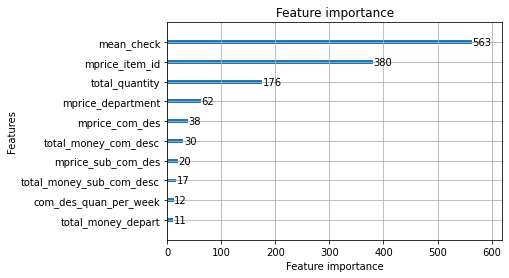

In [82]:
lightgbm.plot_importance(lgb_model, max_num_features=10)

# 5. Получение результата

In [91]:
!cp /content/drive/'My Drive'/test.csv /content

In [92]:
test_ds = pd.read_csv('test.csv')

In [96]:
# Применяем модель первого уровня
test_ds['candidates'] = test_ds['user_id'].apply(lambda x: als_model.get_als_recommendations(x, N=50))

,user_id,recomendations,candidates
0,1,"[874972, 1132231, 1131321, 940947, 1075074]","[1075074, 5577022, 856942, 9527558, 15926844, ..."
1,2,"[874972, 1116821, 960791, 947798, 1053690]","[1103898, 970481, 7410341, 939900, 826784, 809..."


In [97]:
# Разварачиваем датасет

s = test_ds.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

test_ds = test_ds.drop('candidates', axis=1).join(s)
#test_ds['drop'] = 1  # фиктивная переменная

In [98]:
# Добавляем признаки из item_features
test_ds = test_ds.merge(item_features[['item_id','department',\
                                                   'commodity_desc','sub_commodity_desc']], \
                                                    on='item_id', how='left')
# Средний чек для каждого пользователя
test_ds = test_ds.merge(mean_check, on='user_id', how='left')
# Средняя стоимость для каждого товара
test_ds = test_ds.merge(mprice_item_id, on='item_id', how='left')
# Средняя стоимость товаров из department, которые купил пользователь
test_ds = test_ds.merge(mprice_department, on=['user_id', 'department'], how='left')
# Средняя стоимость товаров из commodity_desc, которые купил пользователь
test_ds = test_ds.merge(mprice_com_des, on=['user_id', 'commodity_desc'], how='left')
# Средняя стоимость товаров из sub_commodity_desc, которые купил пользователь
test_ds = test_ds.merge(mprice_sub_com_des, on=['user_id', 'sub_commodity_desc'], how='left')
# Сколько раз данный пользователь купил данный товар за всю историю
test_ds = test_ds.merge(total_quantity, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю
test_ds = test_ds.merge(total_sales_value, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на данный товар за всю историю с учетом времени
test_ds = test_ds.merge(total_sales_value_t, on=['user_id', 'item_id'], how='left')
# Сколько денег данный пользователь потратил на товары из department за всю историю
test_ds = test_ds.merge(total_money_depart, on=['user_id', 'department'], how='left')
# Сколько денег данный пользователь потратил на товары из commodity_desc за всю историю
test_ds = test_ds.merge(total_money_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Сколько денег данный пользователь потратил на товары из sub_commodity_desc за всю историю
test_ds = test_ds.merge(total_money_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')

# Общее количество покупок данного пользователя товаров из department за всю историю
test_ds = test_ds.merge(total_quantity_depart, on=['user_id', 'department'], how='left')
# Общее количество покупок данного пользователя товаров из commodity_desc за всю историю
test_ds = test_ds.merge(total_quantity_com_desc, on=['user_id', 'commodity_desc'], how='left')
# Общее количество покупок данного пользователя товаров из sub_commodity_desc за всю историю
test_ds = test_ds.merge(total_quantity_sub_com_desc, on=['user_id', 'sub_commodity_desc'], how='left')
# Частотность покупок каждого пользователя
test_ds = test_ds.merge(quantity_per_week, on=['user_id'], how='left')
# Средняя сумма, которую пользователь тратит в неделю
test_ds = test_ds.merge(sales_value_per_week, on=['user_id'], how='left')
# Количество продаж данного товара в неделю
test_ds = test_ds.merge(item_quan_per_week, on=['item_id'], how='left')
# Количество продаж товаров из department в неделю
test_ds = test_ds.merge(depart_quan_per_week, on=['department'], how='left')
# Количество продаж товаров из commodity_desc в неделю
test_ds = test_ds.merge(com_des_quan_per_week, on=['commodity_desc'], how='left')
# Количество продаж товаров из sub_commodity_desc в неделю
test_ds = test_ds.merge(sub_com_des_quan_per_week, on=['sub_commodity_desc'], how='left')
# Средняя цена товаров в категории department
test_ds = test_ds.merge(department_mprice, on=['department'], how='left')
# Средняя цена товаров в категории commodity_desc
test_ds = test_ds.merge(com_des_mprice, on=['commodity_desc'], how='left')
# Средняя цена товаров в категории sub_commodity_desc
test_ds = test_ds.merge(sub_com_des_mprice, on=['sub_commodity_desc'], how='left')

# Надо поделить mprice_item_id на sub_com_des_mprice
test_ds['item_mp/scd_mp'] = test_ds['mprice_item_id']/test_ds['sub_com_des_mprice']

# Добавляем признаки из user_features
test_ds = test_ds.merge(user_features[['user_id','age_desc','income_desc','household_size_desc']], on=['user_id'], how='left')

#test_ds = test_ds.merge(als_user_fearures, on=['user_id'], how='left')
#test_ds = test_ds.merge(als_item_fearures, on=['item_id'], how='left')

#test_ds['total_quantity'] = test_ds['total_quantity'].fillna(0)
#test_ds['item_sv_user'] = test_ds['item_sv_user'].fillna(0)

In [102]:
test_preds = lgb_model.predict_proba(test_ds.drop(['department', 'commodity_desc', 'sub_commodity_desc', 'item_id', 'user_id', 'recomendations'], axis=1))[:, 1]

recomendations = test_ds[['user_id',	'item_id']]

recomendations['prob'] = test_preds
recomendations.sort_values(by = ['user_id', 'prob'], ascending=False, inplace=True)
recomendations.head(3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,item_id,prob
94217,2500,931672,1.0
94218,2500,859237,1.0
94228,2500,897274,1.0


In [103]:
# Группируем товары для каждого пользователя
recomendations = recomendations.groupby('user_id')['item_id'].unique().reset_index()
recomendations.columns = ['user_id', 'lgbm_candidates']
recomendations['lgbm_candidates'] = recomendations['lgbm_candidates'].apply(lambda x: x.tolist()) # Чтобы конкатенировать можно было
recomendations.head(3)

,user_id,lgbm_candidates
0,1,"[1075074, 5577022, 856942, 9527558, 877391, 92..."
1,2,"[1103898, 970481, 1133018, 834826, 9419444, 93..."
2,3,"[1056005, 12810393, 916381, 930917, 9527494, 9..."


In [104]:
# Добавляем собственные покупки
recomendations['own_recommender'] = recomendations['user_id'].apply(lambda x: level_2_model.get_own_recommendations(x, 50))
# Добавляем all_top_items
recomendations['all_top_items'] = recomendations['user_id'].apply(lambda x: level_2_model.get_all_top_items())
# Добавляем  top_items_in_users_basket
recomendations['top_items_in_users_basket'] = recomendations['user_id'].apply(lambda x: level_2_model.get_top_items_in_users_basket(x))
# Добавляем top_items_for_user
recomendations['top_items_for_user'] = recomendations['user_id'].apply(lambda x: level_2_model.get_top_items_for_user(x))

In [105]:
# На основе полученного датасета выполняем постфильтрацию
recomendations['result'] = recomendations.apply(lambda row: level_2_filter.postfilter_items(
    user_id = row['user_id'],
    lgbm_candidates = row['lgbm_candidates'],
    own_recommender = row['own_recommender'],
    all_top_items = row['all_top_items'],
    top_items_in_users_basket = row['top_items_in_users_basket'],
    top_items_for_user = row['top_items_for_user']
), axis=1)

In [106]:
# Вычислим длины всех предложений
recomendations['row_len'] = recomendations['result'].apply(lambda x: len(x))

print('Кол-во рекомендаций с длиной != 5 ', recomendations[recomendations['row_len'] != 5].shape[0])

Кол-во рекомендаций с длиной != 5  0


In [109]:
recomendations = recomendations[['user_id', 'result']]

In [111]:
recomendations.to_csv('test.csv')

In [83]:
# Добавить для пользователей признак - частотность похода в магазин (по корзинам)
# Предфильрация для train_lvl_2 - убрать дорогие (или вообще prefilerом обработать)
# Попробовать моделью первого уровня сделать и постфильтр

# Признак для бустинга - число уникальных пользователей, купивших данный товар